In [3]:
import seaborn
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import OPTICS
from sklearn.cluster import Birch
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use("ggplot")
#plt.usetex = True
from tqdm import tqdm

100%|██████████| 20/20 [02:06<00:00,  6.33s/it]
1.0
(120, 120)


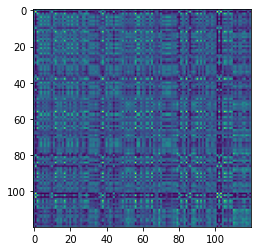

In [5]:
diviser = 100
vocabulary  = list(range(128))
data_T4 = np.load('C:/Users/admin/Documents/Test_script_python/t4_int.npy', allow_pickle=True)[()]
nv = len(data_T4.keys())
t4_ = np.zeros((nv, 128))
for ix, k in enumerate(data_T4.keys()):
    unique_T4, counts_T4 = np.unique(data_T4[k], return_counts=True)
    t4_[ix, unique_T4.astype(int)] = counts_T4/diviser


t4_ = np.around(t4_)
docs = []
npatients, nvocabulary = t4_.shape
for n in range (npatients):
    current_doc = []
    doc = t4_[n,:]
    for i in range(nvocabulary):
        for _ in range(int(doc[i])):
            current_doc.append(i)
    docs.append(current_doc)
            
        

D = len(docs)        # number of documents
V = len(vocabulary)  # size of the vocabulary 
T = 4             # number of topics

alpha = 1 / T         # the parameter of the Dirichlet prior on the per-document topic distributions
beta = 1 / T        # the parameter of the Dirichlet prior on the per-topic word distribution


z_d_n = [[0 for _ in range(len(d))] for d in docs]  # z_i_j
theta_d_z = np.zeros((D, T))
phi_z_w = np.zeros((T, V))
n_d = np.zeros((D))
n_z = np.zeros((T))

## Initialize the parameters
# m: doc id
for d, doc in enumerate(docs):  
    # n: id of word inside document, w: id of the word globally
    for n, w in enumerate(doc):
        # assign a topic randomly to words
        z_d_n[d][n] = int(np.random.randint(T))
        # get the topic for word n in document m
        z = z_d_n[d][n]
        # keep track of our counts
        theta_d_z[d][z] += 1
        phi_z_w[z, w] += 1
        n_z[z] += 1
        n_d[d] += 1

for iteration in tqdm(range(20)):
    for d, doc in enumerate(docs):
        for n, w in enumerate(doc):
            # get the topic for word n in document m
            z = z_d_n[d][n]

            # decrement counts for word w with associated topic z
            theta_d_z[d][z] -= 1
            phi_z_w[z, w] -= 1
            n_z[z] -= 1

            # sample new topic from a multinomial according to our formular
            p_d_t = (theta_d_z[d] + alpha) / (n_d[d] - 1 + T * alpha)
            p_t_w = (phi_z_w[:, w] + beta) / (n_z + V * beta)
            p_z = p_d_t * p_t_w
            p_z /= np.sum(p_z)
            #new_z = np.random.multinomial(1, p_z).argmax()
            new_z = np.random.choice(len(p_z), 1, p=p_z)[0] 

            # set z as the new topic and increment counts
            z_d_n[d][n] = new_z
            theta_d_z[d][new_z] += 1
            phi_z_w[new_z, w] += 1
            n_z[new_z] += 1


norm_theta = theta_d_z.copy()
ns = np.sum(theta_d_z, axis=1)
for i in range(ns.shape[0]):
    norm_theta[i, :] /= ns[i]
print(np.max(norm_theta))
corr_matrix = np.dot(norm_theta, norm_theta.T)
print(corr_matrix.shape)
plt.imshow(corr_matrix)
plt.show()


In [7]:
norm_theta_frame = pd.DataFrame(norm_theta)
index_max_norm_theta = norm_theta_frame.idxmax(axis=1)


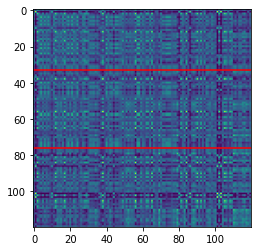

In [9]:
plt.imshow(corr_matrix)
plt.axhline(y=33, color = 'r')
plt.axhline(y=76, color = 'r')
plt.show()

In [11]:
number_of_clusters=4

kmeans = KMeans(n_clusters=number_of_clusters,random_state=1).fit(norm_theta) 
y_kmeans_T4 = kmeans.predict(norm_theta)

spectral = SpectralClustering(n_clusters=number_of_clusters,random_state=1).fit(norm_theta) 
y_spectral_T4 = spectral.labels_

birch_clustering = Birch(threshold=0.01, n_clusters=number_of_clusters).fit(norm_theta)
y_birch_T4 = birch_clustering.predict(norm_theta)

gaussian_clustering = GaussianMixture(n_components=number_of_clusters).fit(norm_theta)
y_gaussian_clustering_T4 = gaussian_clustering.predict(norm_theta)


In [13]:
type_of_clustering = y_spectral_T4


data_to_analyse = pd.concat([pd.Series(type_of_clustering, name = 'Clusters'), pd.Series(pd.Series(data_T4.keys()).str.rsplit('_', n=1).str.get(0), name = 'Status'), pd.Series(data_T4.keys(), name = 'Statut_number'), pd.Series(index_max_norm_theta, name = 'Max_value_Topic_Index')], axis = 1)

In [15]:
sub0 = data_to_analyse[ data_to_analyse['Clusters'] == 0 ]
sub0['Status'].value_counts()
sub1 = data_to_analyse[ data_to_analyse['Clusters'] == 1 ]
sub1['Status'].value_counts()
sub2 = data_to_analyse[ data_to_analyse['Clusters'] == 2 ]
sub2['Status'].value_counts()
sub3 = data_to_analyse[ data_to_analyse['Clusters'] == 3 ]
sub3['Status'].value_counts()

pd.DataFrame([sub0['Status'].value_counts(),sub1['Status'].value_counts(),sub2['Status'].value_counts(), sub3['Status'].value_counts()], index= ['Cluster 0','Cluster 1','Cluster 2','Cluster 3'])

,obd,ob,lean
Cluster 0,10,10,10
Cluster 1,4,1,2
Cluster 2,7,18,15
Cluster 3,23,14,6


In [17]:
acronymes = pd.read_excel('C:/Users/admin/Desktop/Ph.D work/Cell_patient_clustering/Acronyme.xlsx')
acronymes['Statut'] = acronymes['Statut'].str.lower()
acronymes['Statut_number'] = acronymes['Statut'] + str('_')+ pd.Series(acronymes['Patients_file'].str.rsplit('_', n=2).str.get(1))
acronymes

,Acronyme,Patients_file,Statut,Statut_number
0,10MC0704_OW,labeld_specimen_019_new,lean,lean_019
1,14MC0963_OW,labeld_specimen_020_new,lean,lean_020
2,ABDPA,labeld_specimen_023_new,obd,obd_023
3,ADAAH,labeld_specimen_001_new,obd,obd_001
4,AMINA,labeld_specimen_009_new,obd,obd_009
...,...,...,...,...
115,SEPCL,labeld_specimen_009_new,ob,ob_009
116,SQUCA,labeld_specimen_022_new,obd,obd_022
117,TAILY,labeld_specimen_042_new,ob,ob_042
118,TEHFA,labeld_specimen_042_new,obd,obd_042


In [19]:
merged_with_clustering = pd.merge(acronymes, data_to_analyse, on=["Statut_number"])
merged_with_clustering

,Acronyme,Patients_file,Statut,Statut_number,Clusters,Status,Max_value_Topic_Index
0,10MC0704_OW,labeld_specimen_019_new,lean,lean_019,3,lean,3
1,14MC0963_OW,labeld_specimen_020_new,lean,lean_020,2,lean,0
2,ABDPA,labeld_specimen_023_new,obd,obd_023,3,obd,3
3,ADAAH,labeld_specimen_001_new,obd,obd_001,0,obd,1
4,AMINA,labeld_specimen_009_new,obd,obd_009,3,obd,3
...,...,...,...,...,...,...,...
115,SEPCL,labeld_specimen_009_new,ob,ob_009,0,ob,1
116,SQUCA,labeld_specimen_022_new,obd,obd_022,2,obd,0
117,TAILY,labeld_specimen_042_new,ob,ob_042,2,ob,2
118,TEHFA,labeld_specimen_042_new,obd,obd_042,3,obd,3


<AxesSubplot:xlabel='Clusters', ylabel='Age_'>

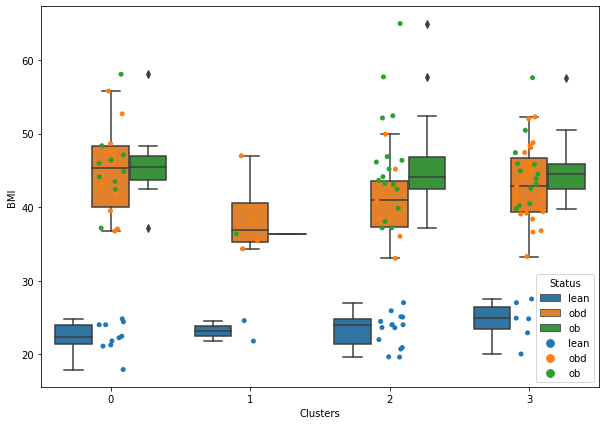

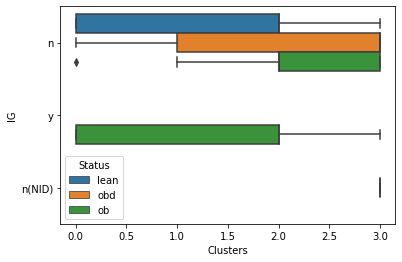

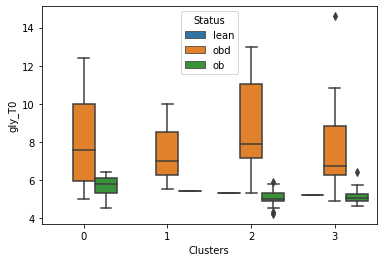

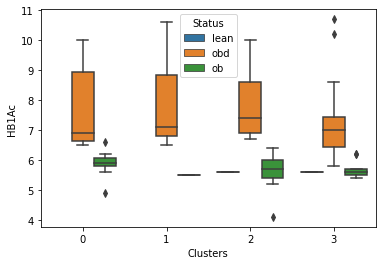

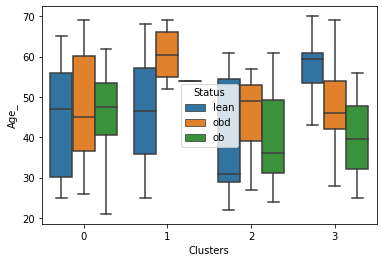

In [21]:
data = pd.read_excel('C:/Users/admin/Desktop/20200921 bio-info full data.xlsx')
new_data = pd.merge(data, merged_with_clustering, on=["Acronyme"])


plt.figure(figsize=(10, 7))
seaborn.boxplot(x = 'Clusters', y = 'BMI',hue = 'Status', data=new_data)
seaborn.stripplot(x = 'Clusters', y = 'BMI', hue = 'Status', data=new_data)

plt.figure()

seaborn.boxplot(x = 'Clusters', y = 'IG',hue = 'Status',data=new_data)
plt.figure()

seaborn.boxplot(x = 'Clusters', y = 'gly_T0',hue = 'Status',data=new_data)
plt.figure()

seaborn.boxplot(x = 'Clusters', y = 'HB1Ac',hue = 'Status',data=new_data)
plt.figure()

seaborn.boxplot(x = 'Clusters', y = 'Age_',hue = 'Status',data=new_data)


<AxesSubplot:xlabel='Clusters', ylabel='Age_'>

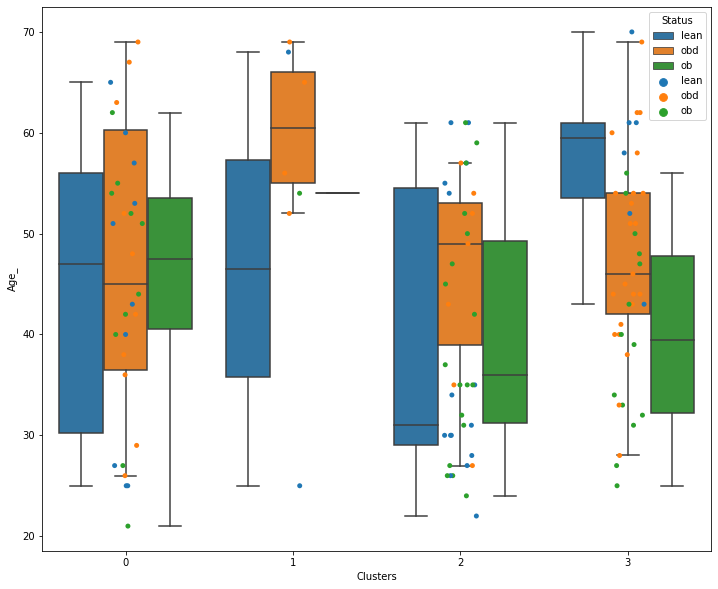

In [23]:
plt.figure(figsize=(12, 10))
seaborn.boxplot(x = 'Clusters', y = 'Age_',hue = 'Status', data=new_data)
seaborn.stripplot(x = 'Clusters', y = 'Age_', hue = 'Status', data=new_data)


<AxesSubplot:xlabel='Max_value_Topic_Index', ylabel='Age_'>

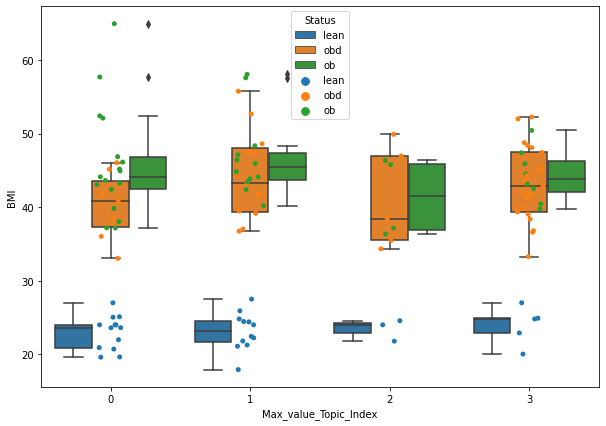

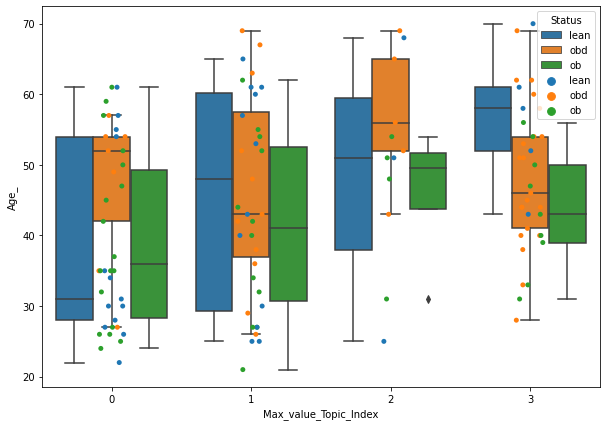

In [25]:
#TOPIC CLUSTERING

plt.figure(figsize=(10, 7))
seaborn.boxplot(x = 'Max_value_Topic_Index', y = 'BMI',hue = 'Status', data=new_data)
seaborn.stripplot(x = 'Max_value_Topic_Index', y = 'BMI', hue = 'Status', data=new_data)


plt.figure(figsize=(10, 7))
seaborn.boxplot(x = 'Max_value_Topic_Index', y = 'Age_',hue = 'Status', data=new_data)
seaborn.stripplot(x = 'Max_value_Topic_Index', y = 'Age_', hue = 'Status', data=new_data)



<AxesSubplot:xlabel='Status', ylabel='Max_value_Topic_Index'>

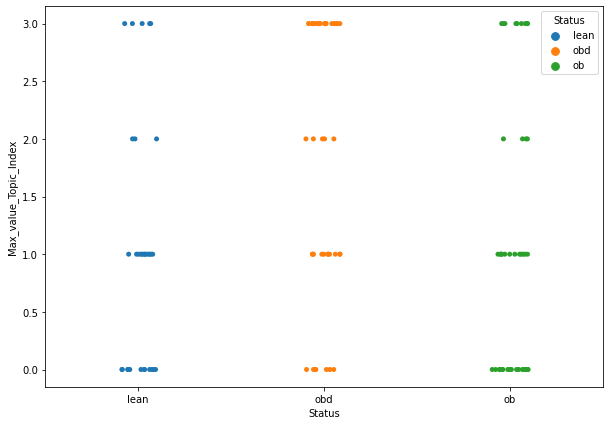

In [26]:
plt.figure(figsize=(10, 7))
seaborn.stripplot(x = 'Status', y = 'Max_value_Topic_Index', hue = 'Status', data=new_data)
